In [ ]:
!pip install snntorch
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import snntorch as snn
from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
from torchvision import datasets, transforms
import itertools

In [ ]:
# Network Architecture
image_size = 5
num_inputs = image_size*image_size
num_hidden = 5
num_outputs = 2

# Training Parameters
batch_size = 128
# Temporal Dynamics
num_steps = 25
alpha = 0.7
beta = 0.8
threshold_value_for_black_and_white = 80
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# read the data
df_test = pd.read_csv('SNNTest.csv')
df_train=pd.read_csv('SNNTraining.csv')
# get the image pixel values and labels
print(df_test.shape)
print(df_train.shape)
batch_size=128
size_of_batch=128
test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]
train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:,1:]

(2114, 785)
(12664, 785)


In [ ]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [ ]:
# Define a transform
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size,image_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            ThresholdTransform(thr_255=threshold_value_for_black_and_white)])

transform_own_data = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size,image_size)),
            
            transforms.ToTensor(),
            ])

In [ ]:
# custom dataset
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(28, 28, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

            # custom dataset
class ownDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(5, 5, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
test_data = MNISTDataset(test_images, test_labels, transform)
train_data = MNISTDataset(train_images, train_labels, transform)
# dataloaders
print(len(train_data))
test_loader = DataLoader(test_data, batch_size=size_of_batch, shuffle=True,drop_last=True)
train_loader = DataLoader(train_data, batch_size=size_of_batch, shuffle=True, drop_last=True)

12664


In [ ]:
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
data_it = data_it.to(device)
targets_it = targets_it.to(device)
time=1e-3

We get single batch here

In [ ]:
print(data_it.size())
data_it[1][0]

torch.Size([128, 1, 5, 5])


tensor([[0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


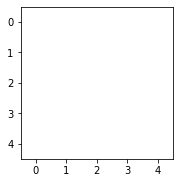

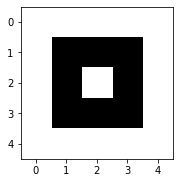

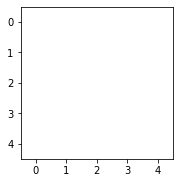

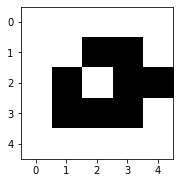

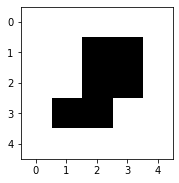

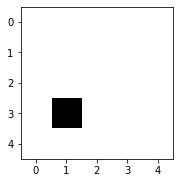

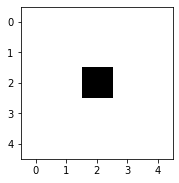

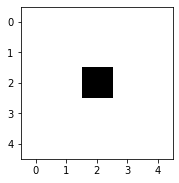

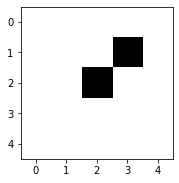

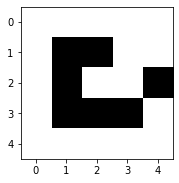

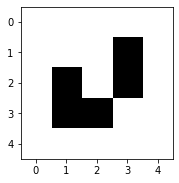

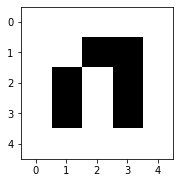

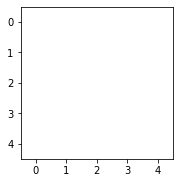

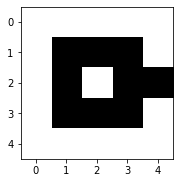

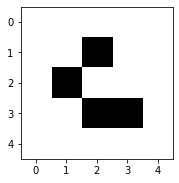

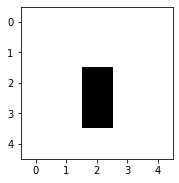

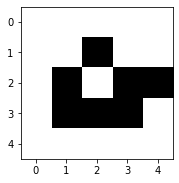

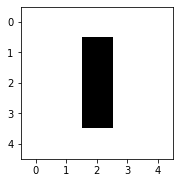

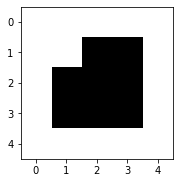

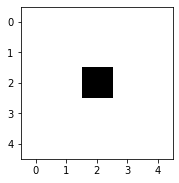

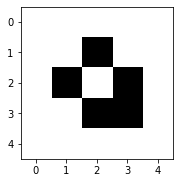

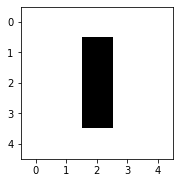

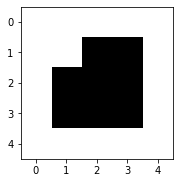

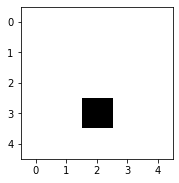

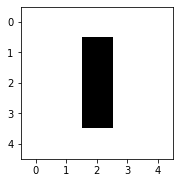

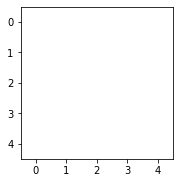

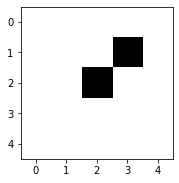

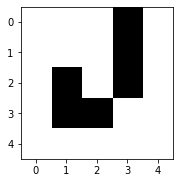

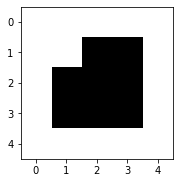

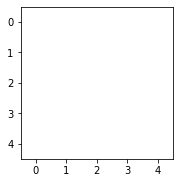

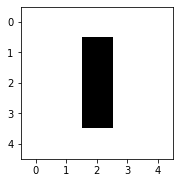

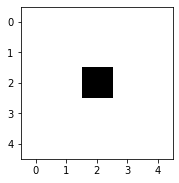

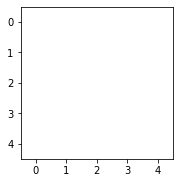

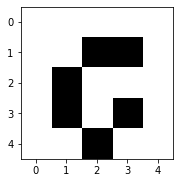

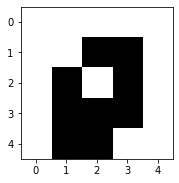

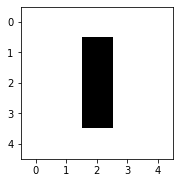

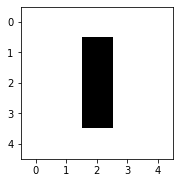

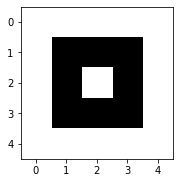

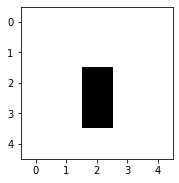

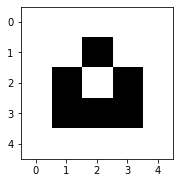

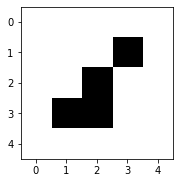

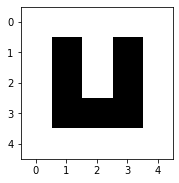

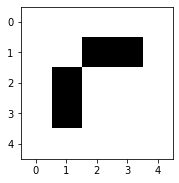

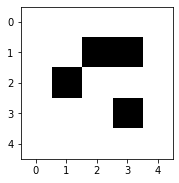

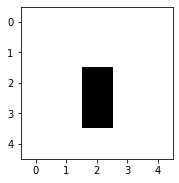

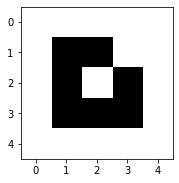

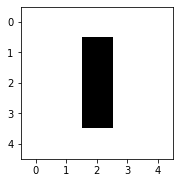

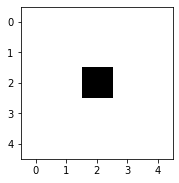

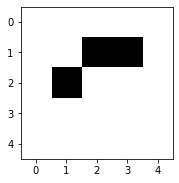

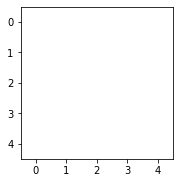

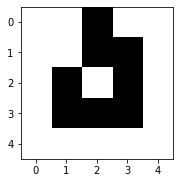

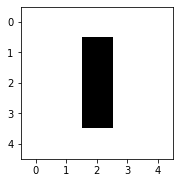

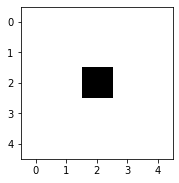

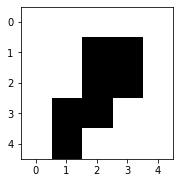

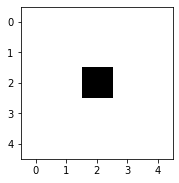

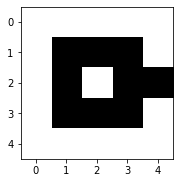

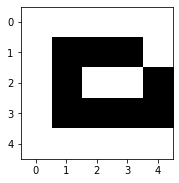

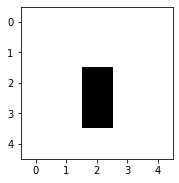

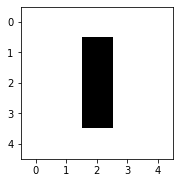

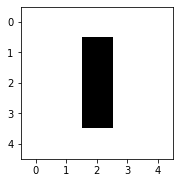

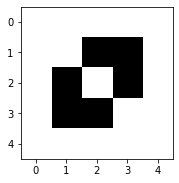

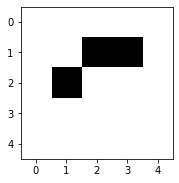

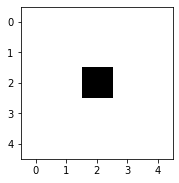

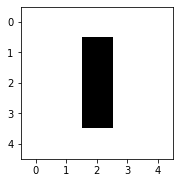

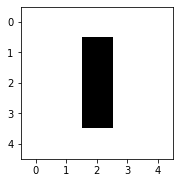

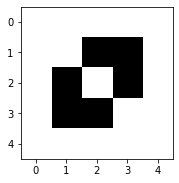

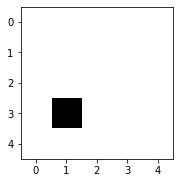

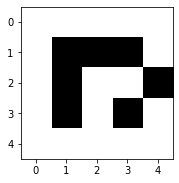

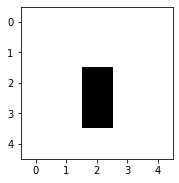

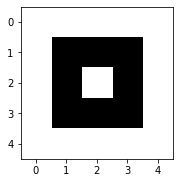

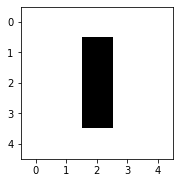

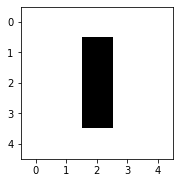

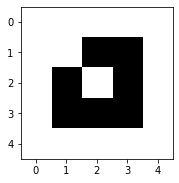

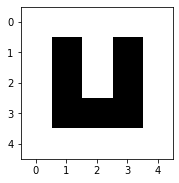

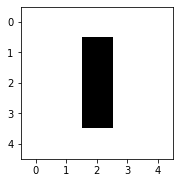

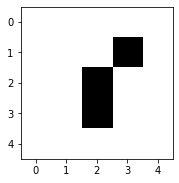

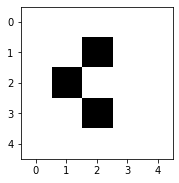

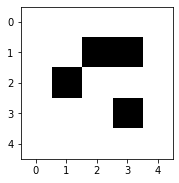

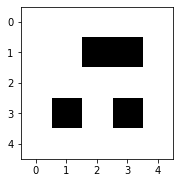

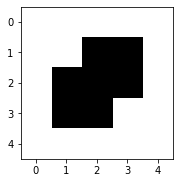

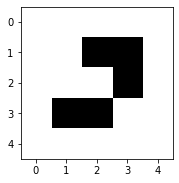

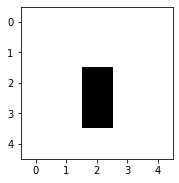

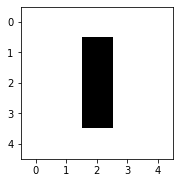

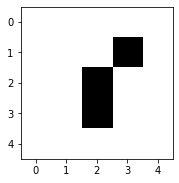

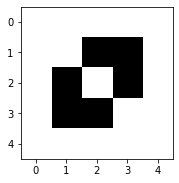

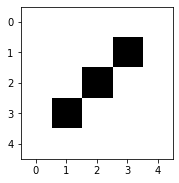

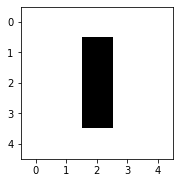

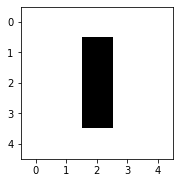

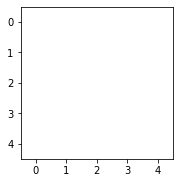

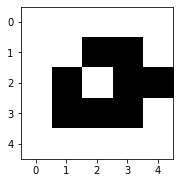

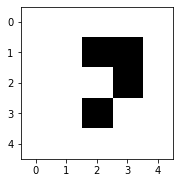

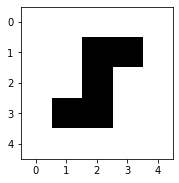

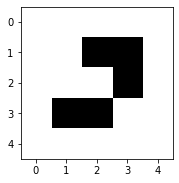

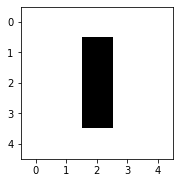

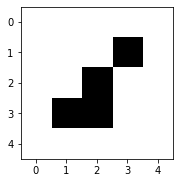

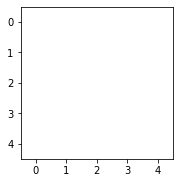

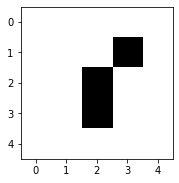

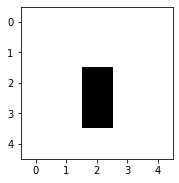

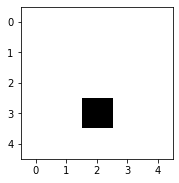

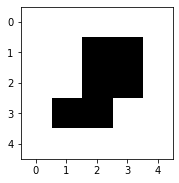

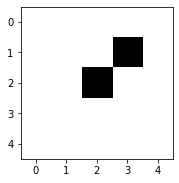

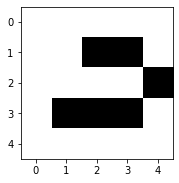

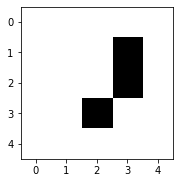

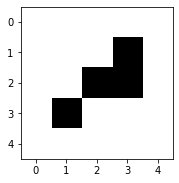

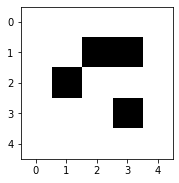

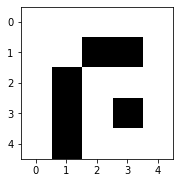

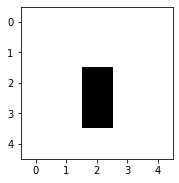

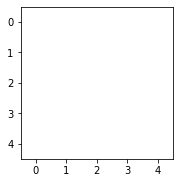

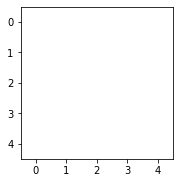

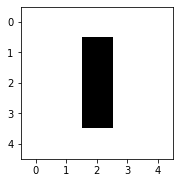

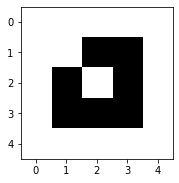

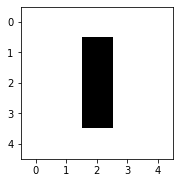

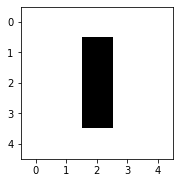

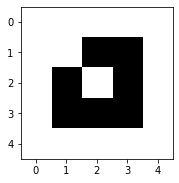

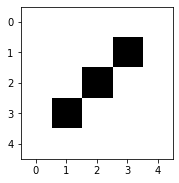

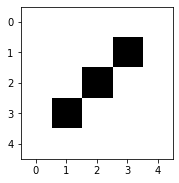

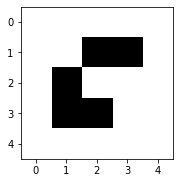

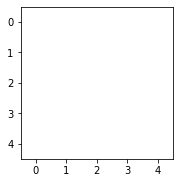

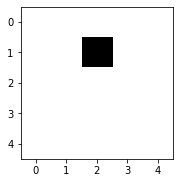

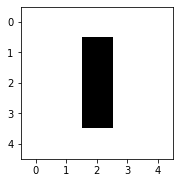

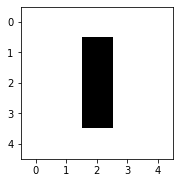

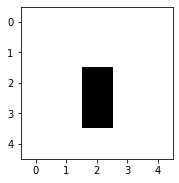

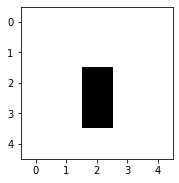

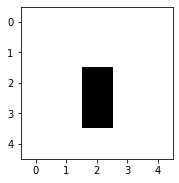

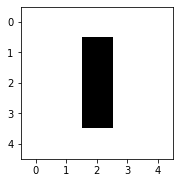

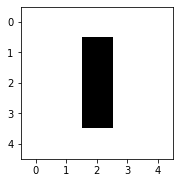

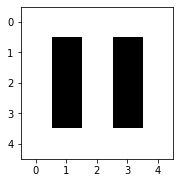

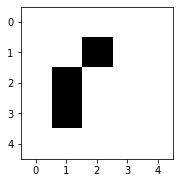

In [ ]:
for i in range(128):
  plt.figure(facecolor="w")
  plt.subplot(1,2,1)
  plt.imshow(data_it[i][0].cpu(), cmap='binary')
  i=i+50

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
          cur1 = self.fc1(x)
          spk1, mem1 = self.lif1(cur1, mem1)
          cur2 = self.fc2(spk1)
          spk2, mem2 = self.lif2(cur2, mem2)
          spk2_rec.append(spk2)
          mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [ ]:
# Load the network onto CUDA if available
net = Net().to(device)

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0
# Outer training loop
for epoch in range(10): 
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)
        #print(data_it[0][0])
        spk_rec, mem_rec = net(data_it.view(batch_size, -1))
        #print(mem_rec.shape)
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()

        # Weight Update
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_spk, test_mem = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: 18.606555938720703
Test Set Loss: 17.993328094482422
Train Set Accuracy: 0.5390625
Test Set Accuracy: 0.5625


Epoch 0, Minibatch 50
Train Set Loss: 17.676870346069336
Test Set Loss: 17.88751792907715
Train Set Accuracy: 0.59375
Test Set Accuracy: 0.5078125


Epoch 1, Minibatch 2
Train Set Loss: 18.216171264648438
Test Set Loss: 17.95298194885254
Train Set Accuracy: 0.4765625
Test Set Accuracy: 0.5390625


Epoch 1, Minibatch 52
Train Set Loss: 17.56573486328125
Test Set Loss: 17.543853759765625
Train Set Accuracy: 0.515625
Test Set Accuracy: 0.5625


Epoch 2, Minibatch 4
Train Set Loss: 17.276208877563477
Test Set Loss: 17.443761825561523
Train Set Accuracy: 0.4921875
Test Set Accuracy: 0.4765625


Epoch 2, Minibatch 54
Train Set Loss: 16.753070831298828
Test Set Loss: 16.930490493774414
Train Set Accuracy: 0.65625
Test Set Accuracy: 0.609375


Epoch 3, Minibatch 6
Train Set Loss: 16.12913703918457
Test Set Loss: 16.180368423461914
Train Set Accurac

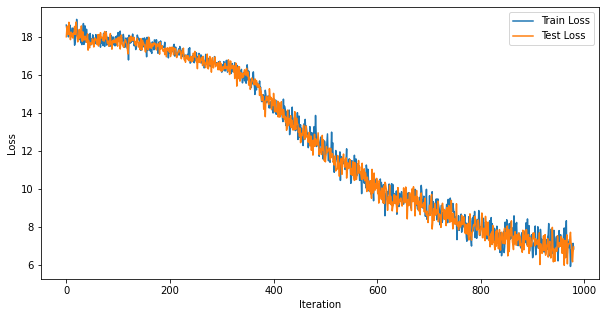

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(test_data, batch_size=size_of_batch, shuffle=True,drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.size(0)  # the final batch has a different size so must be updated
    outputs, _ = net(images.view(batch_size, -1))

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 1949/2048
Test Set Accuracy: 95.166015625%


In [ ]:
torch.save(net,'/content/sample_data/model')

In [ ]:
	model_new = torch.load('/content/sample_data/model')
	model_new.eval()

In [ ]:
with torch.no_grad():
  #for param in model_new.parameters():
    #print(param.data)
  W1,B1,W2,B2=list(model_new.parameters())
print(list(model_new.parameters()))
torch.save(W1,'tensorWeight1.pt')
torch.save(W2,'tensorWeight2.pt')
torch.save(B1,'tensorbias1.pt')
torch.save(B2,'tensorbiast1.pt')

In [ ]:
x_np = W1.cpu().detach().numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('Weight1_Late.csv')

x_np = B1.cpu().detach().numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('Bias1.csv')

x_np = W2.cpu().detach().numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('Weight2.csv')

x_np = B2.cpu().detach().numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('Bias2.csv')

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(test_data, batch_size=size_of_batch, shuffle=True,drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.size(0)  # the final batch has a different size so must be updated
    outputs, _ = net(images.view(batch_size, -1))

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

In [ ]:
# Define Network
class Net1(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc1.weight = torch.nn.Parameter(W1)
        self.fc1.bias = torch.nn.Parameter(B1)
        #self.fc1.bias=B1
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.fc2.weight = torch.nn.Parameter(W2)
        self.fc2.bias = torch.nn.Parameter(B2)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
          cur1 = self.fc1(x)
          spk1, mem1 = self.lif1(cur1, mem1)
          cur2 = self.fc2(spk1)
          spk2, mem2 = self.lif2(cur2, mem2)
          spk2_rec.append(spk2)
          mem2_rec.append(mem2)
         
          # print(" \n weights of layer 1 ",self.fc1.weight)
          # print("\n weights of layer 2 ",self.fc2.weight)
          # print("\n \n values for the time step ",step)
          # print("the size of input x is ",x.shape)
          # print("\n the value of input x is ",x)
          # print("\n size of current 1 is  ",cur1.shape)
          # print("\n current 1 is ",cur1)
          # print("\n size of output of hidden layer that is currrent 2 or spk1 is",spk1.shape)
          # print("\n output of hidden layer that is currrent 2 or spk1 is",spk1)
          # print("\n size of current 1 is  ",cur1.shape)
          # print("\n size of membrane is  ",mem1.shape)
          # print("\n membrane 1 is ",mem1)
          # print("\n membrane 2 is ",mem2)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [ ]:
 net1 = Net1().to(device)

In [ ]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(test_data, batch_size=size_of_batch, shuffle=True,drop_last=False)

with torch.no_grad():
  net1.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    batch_size = images.size(0)  # the final batch has a different size so must be updated
    outputs, _ = net(images.view(batch_size, -1))

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")